In [1]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
from pathlib import Path

path_ct = "/Users/tkimura/Desktop/Blender/A2/元のデータ・臨床データ/DICOM(A2)/匿名化 A0.8/匿名化.Seq19.Ser5.Img1.dcm"
storage_path = "/Users/tkimura/Desktop/Blender/A2/元のデータ・臨床データ/JPEG_FULL_A"

files = [] 
for fname in glob.glob(path_ct[:-7] + "*", recursive=False):
    files.append(pydicom.dcmread(fname))

slicecount = 0
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation') or hasattr(f, 'ImagePositionPatient'):
        slicecount += 1
    else:
        skipcount += 1
         
print("Number of files: {}".format(slicecount))
print("Number of files without slice location: {}".format(skipcount))

# Align the order of slices based on ImagePositionPatient (Z coordinate) if SliceLocation is not available
files = sorted(files, key=lambda s: s.ImagePositionPatient[2] if hasattr(s, 'ImagePositionPatient') else 0)


/Users/tkimura/anaconda3/lib/python3.11/site-packages/pydicom/charset.py:754: UserWarning: Unknown encoding 'ISO 2202 IR 13' - using default encoding instead
  _warn_about_invalid_encoding(encoding)


Number of files: 351
Number of files without slice location: 0


In [2]:
# Calculate ratio in xyz direction

ps = files[0].PixelSpacing  # ピクセル間隔
ss = getattr(files[0], 'SliceThickness', 1.0)  # SliceThickness が存在しない場合、デフォルト値1.0を設定

#スライスの間隔を調べる
ds1 = pydicom.dcmread(path_ct[:-5]+"1.dcm")
ds2 = pydicom.dcmread(path_ct[:-5]+"2.dcm")
ds1_p = ds1.ImagePositionPatient
ds2_p = ds2.ImagePositionPatient
sd_sub = ds2_p[2]- ds1_p[2]
sd = abs(sd_sub)
sag_aspect = sd/ps[0]        # Ratio of z-direction to y-direction
cor_aspect = sd/ps[1]          # Ratio of z-direction to x-direction
print("pixel pitch：{}mm".format(ps))
print("slice distance：{} mm".format(sd))
print("slice thickness:{} mm".format(ss))
print("vertical to horizontal ratio：{}".format(sag_aspect))

pixel pitch：[0.683, 0.683]mm
slice distance：0.7999999999999545 mm
slice thickness:1.0 mm
vertical to horizontal ratio：1.1713030746705044


In [3]:
# make vacant numpy 3D array to import DICOM data  
img_shape = list(files[0].pixel_array.shape) 
img_shape.insert(0,len(files)) 
img3d = np.zeros(img_shape) 
print("size of 3D array:{}".format(img_shape))#size of numpy 3D array

# import DICOM data to numpy 3D array
for i, s in enumerate(files):
    img2d = s.pixel_array  
    img3d[i,:, :] = img2d    

size of 3D array:[351, 512, 512]


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
import numpy as np

def f(k, l, m):
    fig, ax=plt.subplots(figsize=(ps[0]*img_shape[1] * 0.025, ps[1] * img_shape[2] * 0.025)) #横×縦
    plt.imshow(img3d[m,: :], cmap=plt.cm.gray, vmin =l-k , vmax = l+k)
    plt.show()

interact(f, k=(0,300,5), l=(-100, 1400,5), m=(0, slicecount-1, 1))

interactive(children=(IntSlider(value=150, description='k', max=300, step=5), IntSlider(value=650, description…

<function __main__.f(k, l, m)>

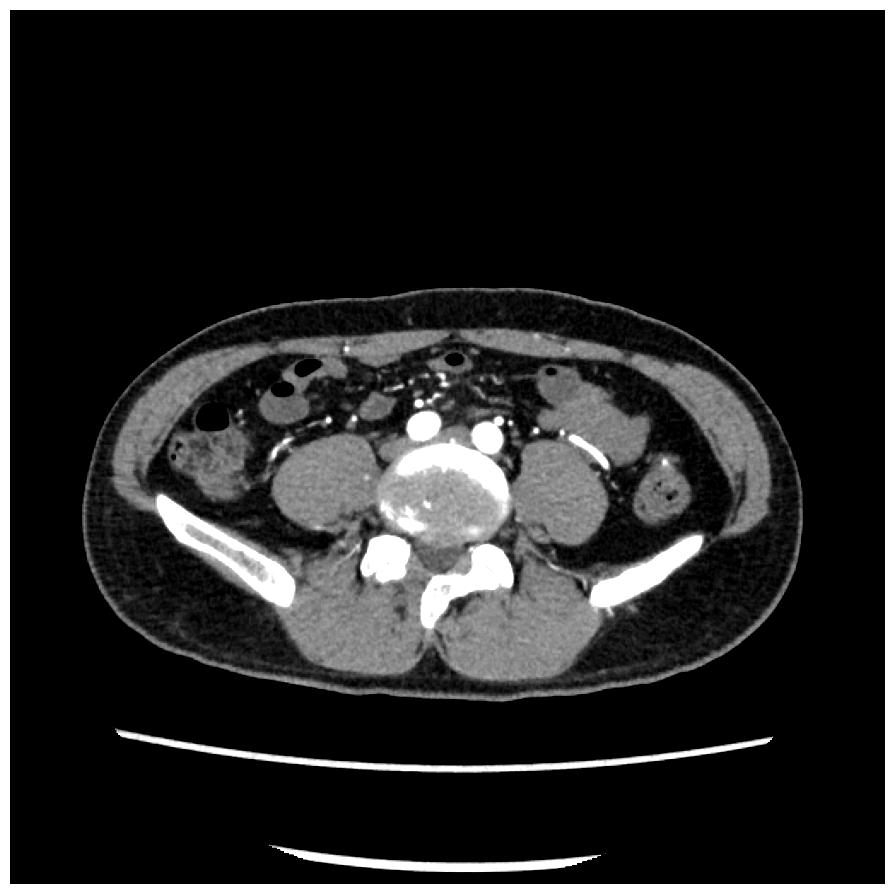

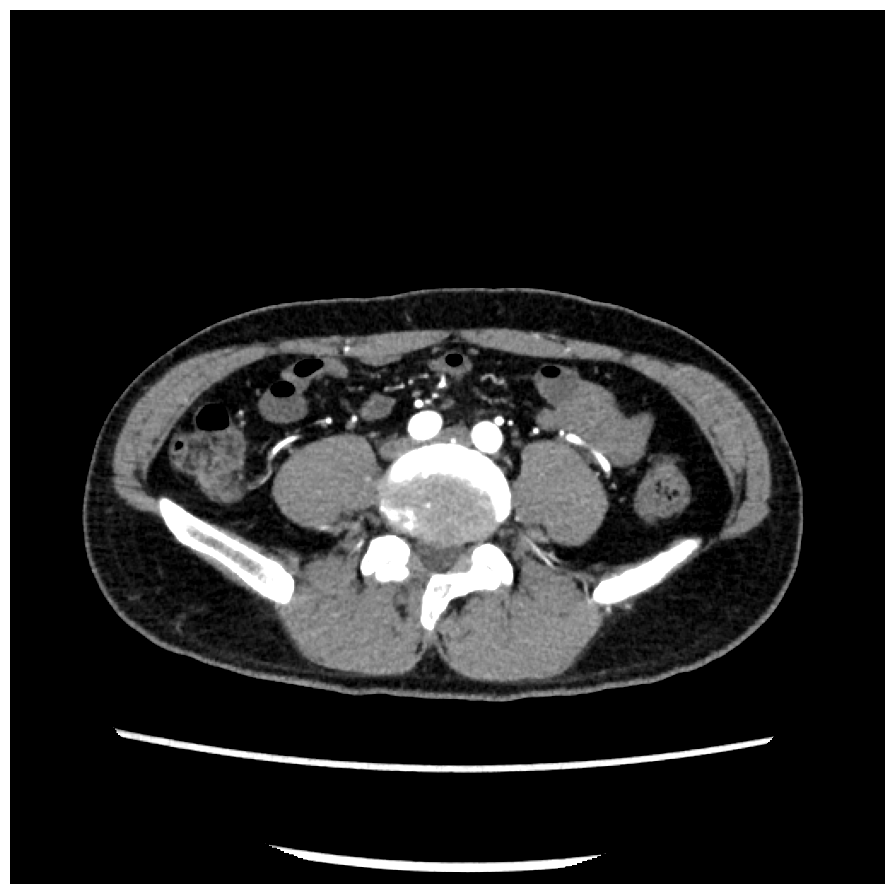

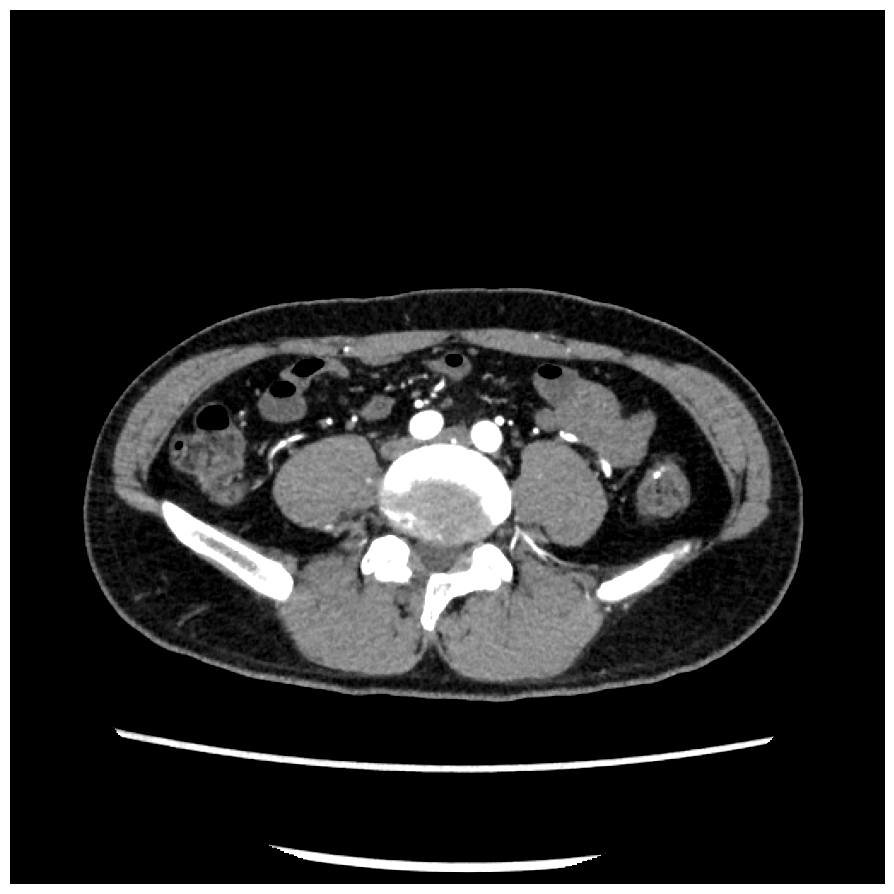

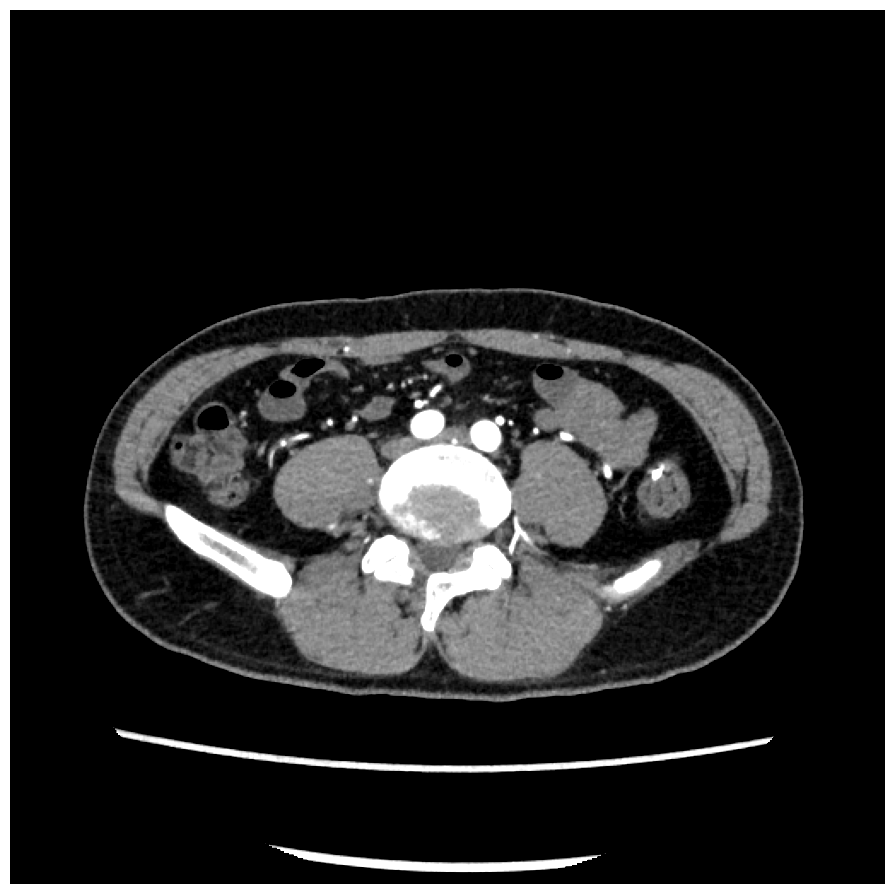

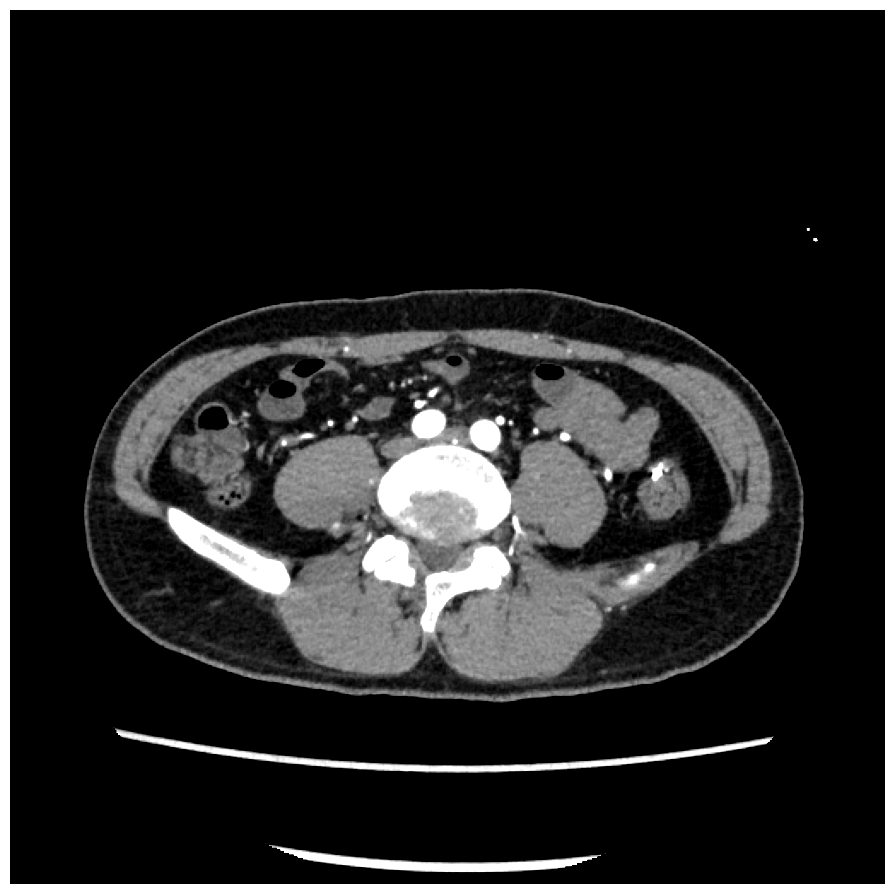

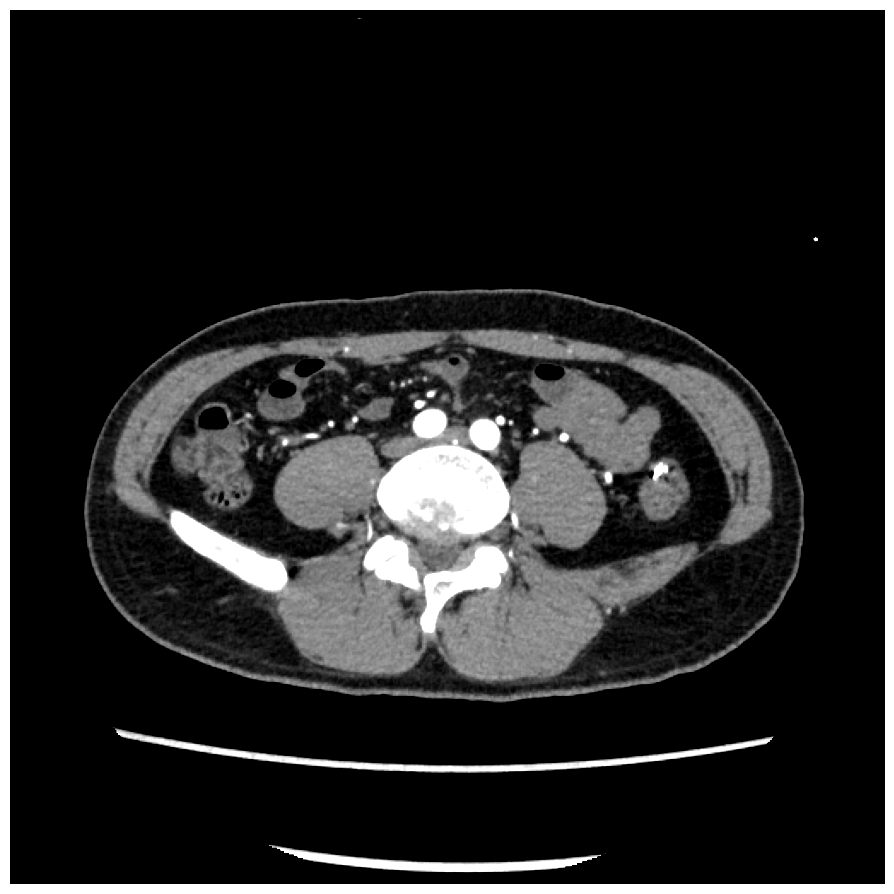

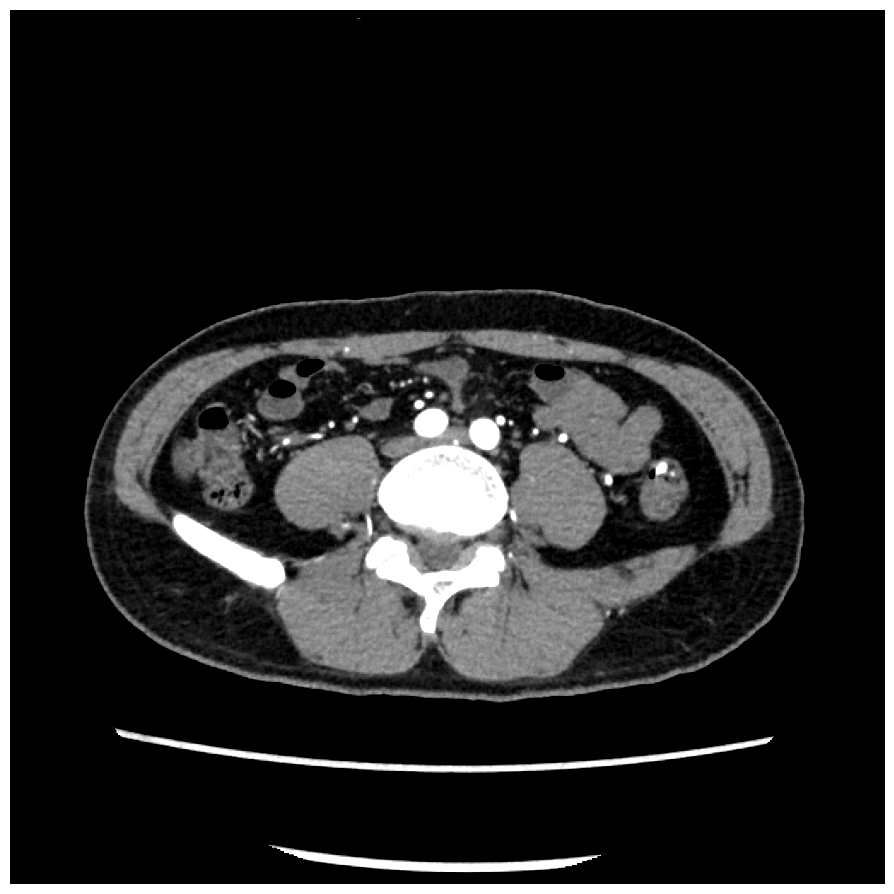

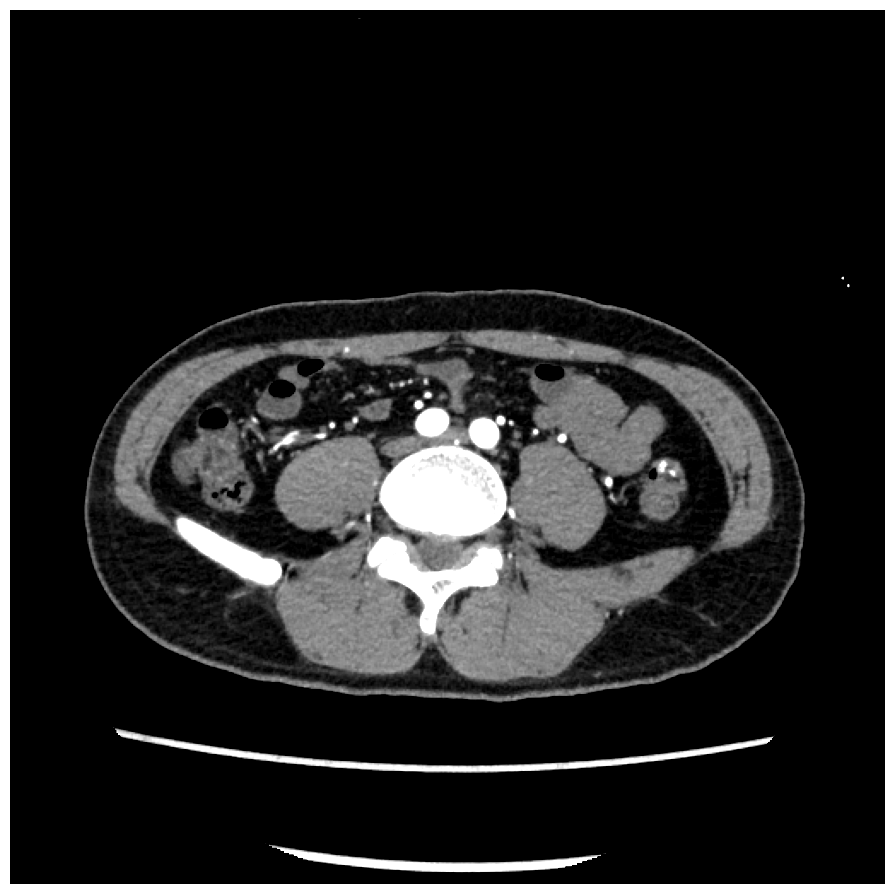

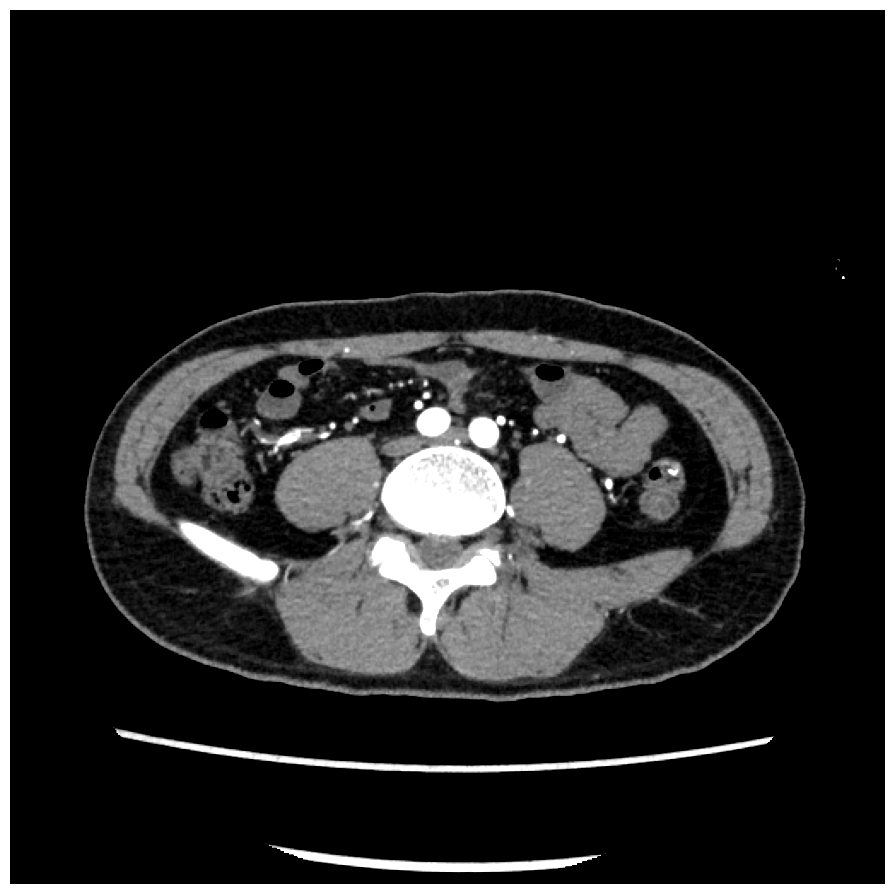

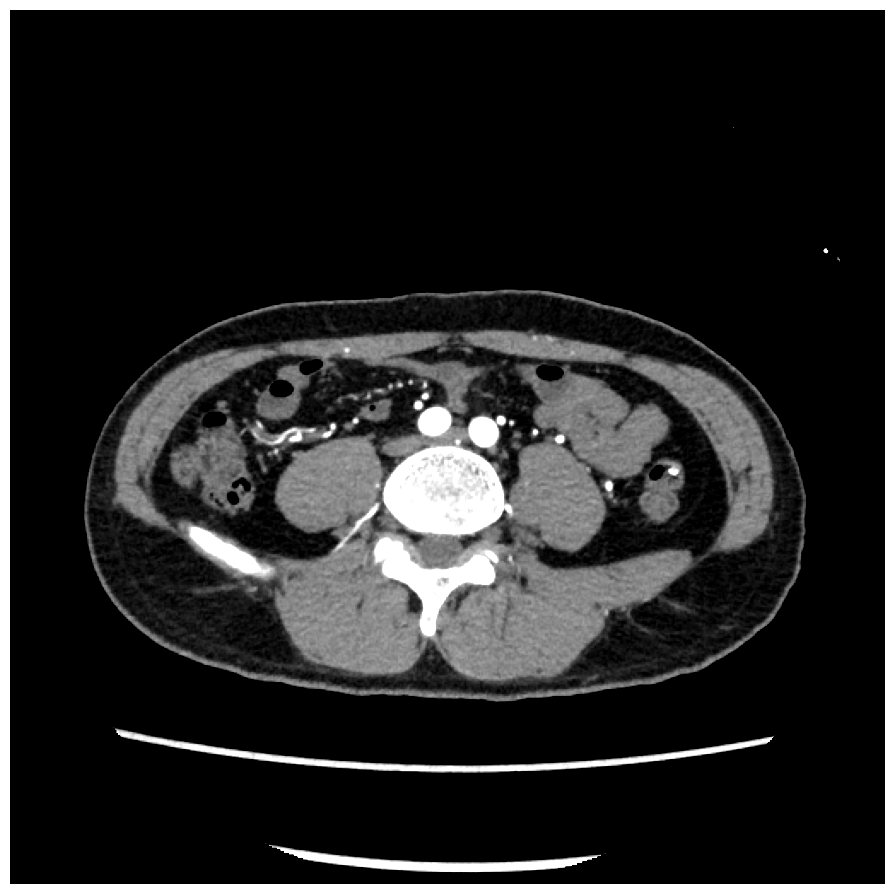

In [ ]:
#make JPEG format MPR image, name the files and save in the specified folder
#define interval 
interval_ax = 1
interval_cor = 1
interval_sag = 1
#Prepare folders named "A" and "C" and "S" in the same storage folder 
#copy and path the path of the storage folder between ' and ' below(no space)
storage_path = Path(storage_path)
                
folder_A = "A"
folder_C = "C"
folder_S = "S"
path_A = storage_path / folder_A
path_C = storage_path / folder_C
path_S = storage_path / folder_S

path_A.mkdir(parents=True, exist_ok=True)
path_C.mkdir(parents=True, exist_ok=True)
path_S.mkdir(parents=True, exist_ok=True)

#define resolusion 
dpi = 200
#define window
# vmin = l-k, vmax = l+K
vmin = -135
vmax = 225


# Axial
for j in range(0, len(files),interval_ax):
    fig, ax=plt.subplots(figsize=(ps[1]*img_shape[2] * 0.025, ps[0] * img_shape[1] * 0.025))
    #fig, ax=plt.subplots(figsize=(4,4))
    plt.imshow(img3d[j,: :], cmap=plt.cm.gray, vmin = vmin , vmax = vmax)
    plt.axis('off')
    #a1.set_aspect(ax_aspect)  # ax_aspect = 1
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    save_path_A = storage_path / "A" / f"A{j+1}.jpg"
    plt.savefig(save_path_A, format = "jpg", dpi = dpi)
    plt.show()

# # Cronal
for k in range(0,img_shape[1],interval_cor):
    imgxz=img3d[:,k,:]
    plt.figure(figsize=(ps[1]*img_shape[2]*0.025, sd*len(files)*0.025))
    plt.imshow(imgxz,cmap=plt.cm.gray, vmin = vmin, vmax = vmax, aspect=cor_aspect)
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    save_path_C = storage_path / "C" / f"C{k+1}.jpg"
    plt.savefig(save_path_C, format = "jpg", dpi = dpi)
    plt.show()

# Sagital
for l in range(0,img_shape[2],interval_sag):
    imgyz=img3d[:,:,l]
    plt.figure(figsize=(ps[0]*img_shape[1]*0.025, sd*len(files)*0.025))
    plt.imshow(imgyz,cmap=plt.cm.gray, vmin = vmin, vmax = vmax, aspect=sag_aspect)
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    save_path_S = storage_path / "S" / f"S{l+1}.jpg"
    plt.savefig(save_path_S, format = "jpg", dpi = dpi)
    plt.show()